In [1]:
# packages 
%load_ext autoreload
%autoreload 2

import utils # functions stored here 
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
from matplotlib.colors import LightSource

Python script that shows the difference between linear and nonlinear diffusion of a landscape.

This script follows the Matlab script from de'Michieli Vitturi and Arrowsmith, 2013. doi: 10.1002/esp.3423

Use the original DEM and the linearly and nonlinearly diffused DEMs from the dMV and Arrowsmith article for this script.

Authors: Ramon Arrowsmith and Mindy Zuckerman

In [2]:
# Cell 2: Load DEMs and fixed profile line

# DEM file names - pre diffused
initial_file = "DEMs/E6.asc"
linear_file = "DEMs_linear_non_linear/e6_10m2linear.asc"
nonlinear_file = "DEMs_linear_non_linear/e6_10m2n0.5nonlinear.asc"

X, Y, initial = utils.load_dem(initial_file)
_, _, linear = utils.load_dem(linear_file)
_, _, nonlinear = utils.load_dem(nonlinear_file)

# lidar plotting params
sun_azimuth = 300  # degrees (clockwise from north)
sun_altitude = 30  # degrees above horizon

#  profile line endpoints
line_pts = [(625843.949, 3599466.964), (625904.243, 3599493.325)]

# Y is flipped in load_dem, so Y[0, :] is top row, Y[-1, :] is bottom row
# Find the original max and min Y to flip the profile line y's accordingly

y_min = Y.min()
y_max = Y.max()


def flip_profile_line_y(line_pts, y_min, y_max):
    flipped_pts = []
    for x, y in line_pts:
        y_flipped = y_max - (y - y_min)
        flipped_pts.append((x, y_flipped))
    return flipped_pts


line_pts_flipped = flip_profile_line_y(line_pts, y_min, y_max)

# hillshade arrays
dx = X[0, 1] - X[0, 0]
dy = Y[1, 0] - Y[0, 0]

ls = LightSource(azdeg=sun_azimuth, altdeg=sun_altitude)

hillshade_initial = ls.hillshade(initial, vert_exag=1, dx=dx, dy=dy)
hillshade_linear = ls.hillshade(linear, vert_exag=1, dx=dx, dy=dy)
hillshade_nonlinear = ls.hillshade(nonlinear, vert_exag=1, dx=dx, dy=dy)
hillshade_min = min(
    hillshade_initial.min(), hillshade_linear.min(), hillshade_nonlinear.min()
)
hillshade_max = max(
    hillshade_initial.max(), hillshade_linear.max(), hillshade_nonlinear.max()
)

/opt/homebrew/anaconda3/envs/scarp_erosion/lib/python3.12/site-packages/osgeo/gdal.py:312: FutureWarning: Neither gdal.UseExceptions() nor gdal.DontUseExceptions() has been explicitly called. In GDAL 4.0, exceptions will be enabled by default.
  warnings.warn(


In [3]:
# get swath profiles and calculate slope histograms

# width = 10

dist_init, prof_init = utils.extract_profile(X, Y, initial, line_pts)
_, prof_linear = utils.extract_profile(X, Y, linear, line_pts)
_, prof_nonlinear = utils.extract_profile(X, Y, nonlinear, line_pts)

bins, initial_counts = utils.calc_slope_histogram(
    initial, X[0, 1] - X[0, 0], Y[1, 0] - Y[0, 0]
)
_, linear_counts = utils.calc_slope_histogram(
    linear, X[0, 1] - X[0, 0], Y[1, 0] - Y[0, 0]
)
_, nonlinear_counts = utils.calc_slope_histogram(
    nonlinear, X[0, 1] - X[0, 0], Y[1, 0] - Y[0, 0]
)

### Plot linear and non-linear data + comparison
Fig for paper discussion

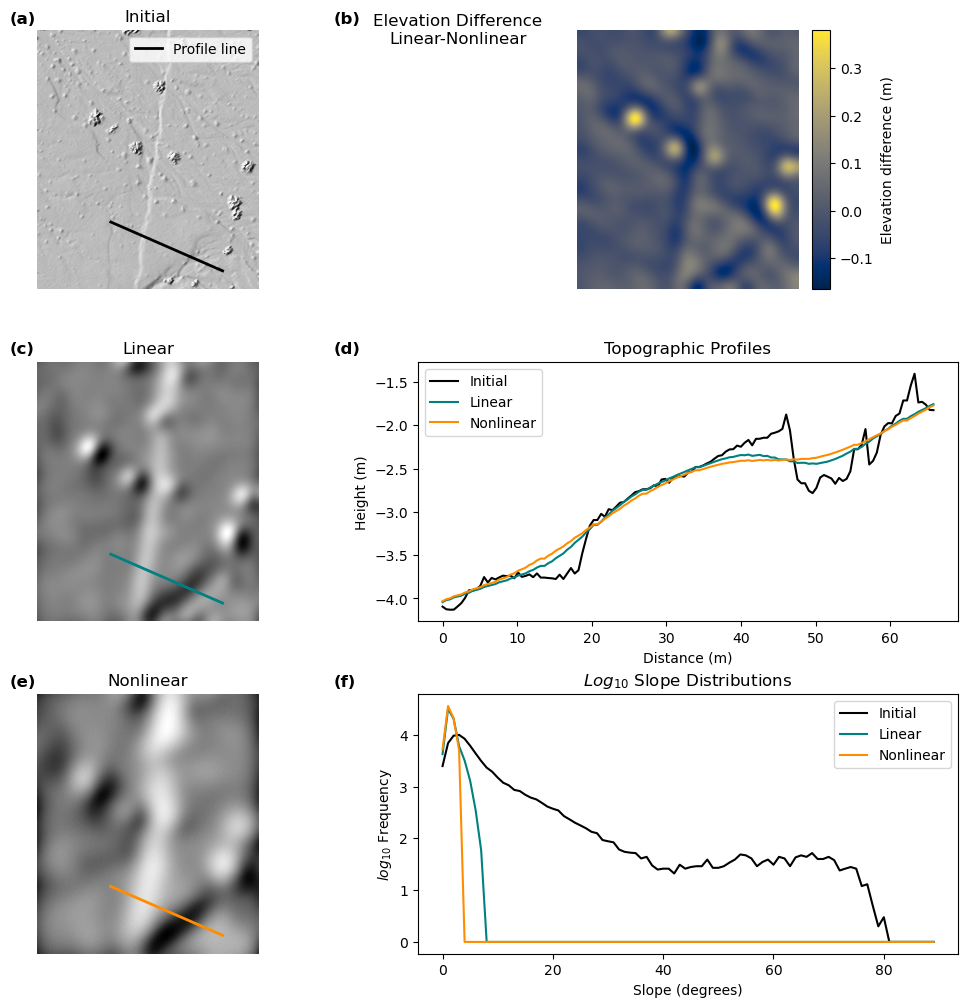

In [4]:
fig, axs = plt.subplots(
    3, 2, figsize=(12, 12), gridspec_kw={"wspace": 0.0, "hspace": 0.28}
)


axs[0, 0].imshow(
    hillshade_initial,
    cmap="gray",
    extent=[X.min(), X.max(), Y.min(), Y.max()],
    vmin=hillshade_min,
    vmax=hillshade_max,
)
axs[0, 0].set_title("Initial")
axs[0, 0].axis("off")

axs[1, 0].imshow(
    hillshade_linear,
    cmap="gray",
    extent=[X.min(), X.max(), Y.min(), Y.max()],
    vmin=hillshade_min,
    vmax=hillshade_max,
)
axs[1, 0].set_title("Linear")
axs[1, 0].axis("off")

axs[2, 0].imshow(
    hillshade_nonlinear,
    cmap="gray",
    extent=[X.min(), X.max(), Y.min(), Y.max()],
    vmin=hillshade_min,
    vmax=hillshade_max,
)
axs[2, 0].set_title("Nonlinear")
axs[2, 0].axis("off")

im = axs[0, 1].imshow(
    linear - nonlinear, cmap="cividis", extent=[X.min(), X.max(), Y.min(), Y.max()]
)

axs[0, 1].axis("off")
# axs[0, 1].set_xlim(625800, 625920)
# axs[0, 1].set_xlabel('Easting (m)')
# axs[0, 1].set_ylabel('Northing (m)')
axs[0, 1].text(
    -0.54,
    1,
    "Elevation Difference\nLinear-Nonlinear",
    fontsize=12,
    rotation=0,
    va="center",
    ha="center",
    transform=axs[0, 1].transAxes,
)
pos = axs[0, 1].get_position()
axs[0, 1].set_position([pos.x0 - 0.1, pos.y0, pos.width, pos.height])


cax = fig.add_axes([pos.x1 + 0.03, pos.y0, 0.015, pos.height])
cbar = fig.colorbar(im, cax=cax)
cbar.set_label("Elevation difference (m)", labelpad=5)


colors = ["black", "teal", "darkorange"]
for i, (ax, color) in enumerate(zip([axs[0, 0], axs[1, 0], axs[2, 0]], colors)):
    ax.plot(
        [pt[0] for pt in line_pts_flipped],
        [pt[1] for pt in line_pts_flipped],
        color=color,
        linewidth=2,
        label="Profile line",
    )
    if i == 0:  # Only add legend on the first subplot
        ax.legend()

ax_prof = axs[1, 1]
ax_prof.plot(dist_init, prof_init, "k-", label="Initial")
ax_prof.plot(dist_init, prof_linear, color="teal", label="Linear")
ax_prof.plot(dist_init, prof_nonlinear, color="darkorange", label="Nonlinear")
ax_prof.set_xlabel("Distance (m)")
ax_prof.set_ylabel("Height (m)")
ax_prof.set_title("Topographic Profiles")
ax_prof.legend()

ax_hist = axs[2, 1]
ax_hist.plot(bins, np.log10(initial_counts + 1), "k-", label="Initial")
ax_hist.plot(bins, np.log10(linear_counts + 1), color="teal", label="Linear")
ax_hist.plot(
    bins, np.log10(nonlinear_counts + 1), color="darkorange", label="Nonlinear"
)
ax_hist.set_xlabel("Slope (degrees)")
ax_hist.set_ylabel("$log_{10}$ Frequency")
ax_hist.set_title("$Log_{10}$ Slope Distributions")
ax_hist.legend()

labels = ["(a)", "(b)", "(c)", "(d)", "(e)", "(f)"]
positions = [
    (0.16, 0.895),  # (a) - top-left
    (0.43, 0.895),  # (b) - top-right
    (0.16, 0.62),  # (c)
    (0.43, 0.62),  # (d)
    (0.16, 0.343),  # (e)
    (0.43, 0.343),  # (f)
]

for label, (x, y) in zip(labels, positions):
    fig.text(x, y, label, fontsize=12, fontweight="bold", ha="left", va="top")

fig.subplots_adjust(left=0.05, right=0.95)